In [2]:
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optax
from functools import partial
import pickle

import sys, os
sys.path.append(os.path.join(os.getcwd(), "../"))
from src.data.data_reader import DataReader

key_number = 8

def key():
    global key_number
    key_number += 1
    return jax.random.PRNGKey(key_number)

In [3]:
def get_data(processed_file):
    with open(processed_file, 'rb') as f:
        sequences = pickle.load(f)
    
    sorted_train_data = []
    for idx, (ts, xs, ts_eval, ys_eval) in enumerate(sequences):
        t0 = ts[0]
        t_ms = (ts - t0) / 1e6 # Convert nanoseconds to milliseconds
        te_ms = (ts_eval - t0) / 1e6

        if len(t_ms) != len(xs):
            print(f"Warning: Inconsistent lengths in sequence {idx}: len(t_ms)={len(t_ms)}, len(xs)={len(xs)}")
            continue  

        if len(te_ms) != len(ys_eval):
            print(f"Warning: Inconsistent lengths in ts_eval and ys_eval in sequence {idx}")
            continue 
        
        sorted_indices = np.argsort(t_ms)
        t_ms = t_ms[sorted_indices]
        xs = xs[sorted_indices]

        sorted_indices = np.argsort(te_ms)
        te_ms = te_ms[sorted_indices]
        ys_eval = ys_eval[sorted_indices]

        # Keep data as arrays
        sorted_train_data.append((t_ms, xs, te_ms, ys_eval))


    if not sorted_train_data:
        raise ValueError("No valid sequences found in the processed data.")

    return sorted_train_data

def dataloader(sequences, batch_size, subset_size, *, key):
    dataset_size = len(sequences[0])
    assert all(len(seq) == dataset_size for seq in sequences)
    indices = np.arange(dataset_size)

    while True:
        subset_perm = np.random.choice(indices, size=subset_size, replace=False)

        start = 0
        end = batch_size

        while start < subset_size:
            batch_perm = subset_perm[start:end]
            # Ensure data remains as arrays
            batch = [ [seq[i] for i in batch_perm] for seq in sequences ]
            yield batch
            start = end
            end = start + batch_size

In [4]:
data = get_data("../data/processed/Visa_2024-09-06.pkl")

In [5]:
print(len(data))
print(len(data[0]))
print(len(data[0][0]))
print(len(data[0][1]))
print(len(data[0][2]))
print(len(data[0][3]))

print(len(data[1]))
print(len(data[1][0]))
print(len(data[1][1]))
print(len(data[1][2]))
print(len(data[1][3]))

print(len(data[0][1][0]))
print(type(data[0][1][0]))

# 

1024
4
24
24
8
8
4
24
24
8
8
6
<class 'numpy.ndarray'>


In [6]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)
    

In [7]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size + 1, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size + 1, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=lkey)

    def predict_batch(self, ts_batch, x_batch, ts_eval_batch):
        # ts_batch = [ts.reshape(-1, 1) for ts in ts_batch]
        predictions = jax.vmap(self.predict, in_axes=(0, 0, 0))(ts_batch, x_batch, ts_eval_batch)
        # predictions = []
        # for ts, x, ts_eval in zip(ts_batch, x_batch, ts_eval_batch):
        #     predictions.append(self.predict(ts, x, ts_eval))

        return jnp.array(predictions)

    def predict(self, ts, x, ts_eval):
        ts, x = diffrax.rectilinear_interpolation(ts, x)
        data = jnp.hstack([ts.reshape(-1, 1), x])
        data = jnp.array(data)

        control = diffrax.LinearInterpolation(ts, data)

        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        saveat = diffrax.SaveAt(ts=ts_eval)
        
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6, jump_ts=ts),
            saveat=saveat,
        )
        
        prediction = jax.vmap(lambda y: jnn.relu(self.linear(y))[0])(solution.ys)

        return prediction
    
    def compute_loss_batch(self, ts_batch, x_batch, ts_eval_batch, y_true_batch):
        y_pred = self.predict_batch(ts_batch, x_batch, ts_eval_batch)
        return jnp.mean((y_pred - y_true_batch) ** 2)
    
    def compute_loss(self, ts, x, ts_eval, y_true):
        y_pred = self.predict(ts, x, ts_eval)
        print(y_pred)
        return jnp.mean((y_pred - y_true) ** 2)

In [8]:
data_size = 6
hidden_size = 1
width_size = 4
depth = 2

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=key())

In [9]:
t, x, t_eval, y_eval = data[0]
# t_batch, x_batch, t_eval_batch, y_eval_batch = data[0:8, 0], data[0:8, 1], data[0:8, 2], data[0:8, 3]

# print(type(t_batch[0]))
# print(type(x_batch[0]))
# print(type(t_eval_batch[0]))
# print(type(y_eval_batch[0]))


# print(data[0:8])
# print(len(x))
# print(data[5][0][-2:])
data[5][0][-1] = 2585
t_batch, x_batch, t_eval_batch, y_eval_batch = map(np.array, zip(*data[0:8]))
# t_batch[5][0][-1] = 2585
# print(len(t_batch[0]))

# for i in range(10):
#     t, x, t_eval, y_eval = data[i]
#     # if i == 5:
#     #     t[-1] = 2585
#     try:
#         model.compute_loss(t, x, t_eval, y_eval)
#     except:
#         print("her etresdt easgrs")
#         print(t)
model.compute_loss_batch(t_batch, x_batch, t_eval_batch, y_eval_batch)
# model.compute_loss(data[0:8])

Array(77644.06, dtype=float32)

In [31]:
from equinox import EquinoxRuntimeError

def train(model, train_data, optimizer, steps, batch_size, seq_length, eval_point_ratio, key, subset_size, patience=500, plot_every=500):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    losses = []
    best_loss = float('inf')
    best_model = model
    last_best_step = 0
    step_times = []

    @eqx.filter_value_and_grad
    def loss(model, ts, xs, ts_test, y_true):
        return model.compute_loss_batch(ts, xs, ts_test, y_true) 

    @eqx.filter_jit
    def make_step(model, opt_state, ts, xs, ts_test, y_true):
        value, grads = loss(model, ts, xs, ts_test, y_true)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state
    
    num_params = sum(p.size for p in jax.tree_util.tree_leaves(eqx.filter(model, eqx.is_inexact_array)))
    num_train_points = len(train_data) * seq_length * eval_point_ratio

    print("-" * 60)
    print(f"Number of parameters: {num_params}")
    print(f"Number of data points: {int(num_train_points)}")
    print("-" * 60)

    ts, xs, ts_eval, y_test = zip(*train_data)

    arrays = (jnp.array(ts), jnp.array(xs), jnp.array(ts_eval), jnp.array(y_test))
    data_gen = dataloader(arrays, batch_size, subset_size=subset_size, key=key)

    train_count = 0

    for step in range(steps):
        start_time = time.time()

        # Get the next batch from the dataloader
        ts_batch, xs_batch, ts_test_batch, y_true_batch = next(data_gen)
        ts_batch, xs_batch, ts_test_batch, y_true_batch = jnp.array(ts_batch), jnp.array(xs_batch), jnp.array(ts_test_batch), jnp.array(y_true_batch)
        # ts_batch, xs_batch, ts_test_batch, y_true_batch = map(np.array, zip(*data[batch_num*batch_size: batch_num*(batch_size + 1)]))

        # Perform a training step
        try: 
            train_count += 1
            loss_value, model, opt_state = make_step(model, opt_state, ts_batch, xs_batch, ts_test_batch, y_true_batch)
            losses.append(loss_value)
        


            step_time = time.time() - start_time
            step_times.append(step_time)
            if len(step_times) > 100:
                step_times.pop(0)

            if loss_value < best_loss:
                best_loss = loss_value
                best_model = model
                last_best_step = step

            if step % 100 == 0:
                avg_step_time = sum(step_times) / len(step_times) if step_times else 0
                estimated_time_remaining = avg_step_time * (steps - step - 1)
                if step == 0:
                    print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: -- ")
                else:
                    print(f"Step {step}, Loss: {loss_value:.4f}, Best Loss: {best_loss:.4f}, Estimated Time Remaining: {estimated_time_remaining / 60:.2f} minutes")

            if step % plot_every == 0:
                _, subkey = jr.split(key)
                random_index = jr.randint(subkey, (1,), 0, batch_size).item()
                plt.figure(figsize=(4, 3))
                plt.plot(ts_test_batch[random_index], y_true_batch[random_index], label='Actual', marker='o')
                y_pred = best_model.predict(jnp.expand_dims(ts_batch[random_index], axis=0), jnp.expand_dims(xs_batch[random_index], axis=0), jnp.expand_dims(ts_test_batch[random_index], axis=0))
                y_pred = y_pred.squeeze()
                plt.plot(ts_test_batch[random_index], y_pred, label='Predicted', marker='x')
                plt.xlabel('Time (ts_test)')
                plt.ylabel('Y values')
                plt.title(f'Training Sequence at Step {step}: Actual vs Predicted Y over Time')
                plt.legend()
                plt.grid(True)
                plt.show()
        except EquinoxRuntimeError:
            continue

        if step - last_best_step >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            return best_model

    plt.figure(figsize=(10, 6))
    plt.plot(np.log(losses), label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"train count: {train_count}")

    return best_model

------------------------------------------------------------
Number of parameters: 122
Number of data points: 9830
------------------------------------------------------------


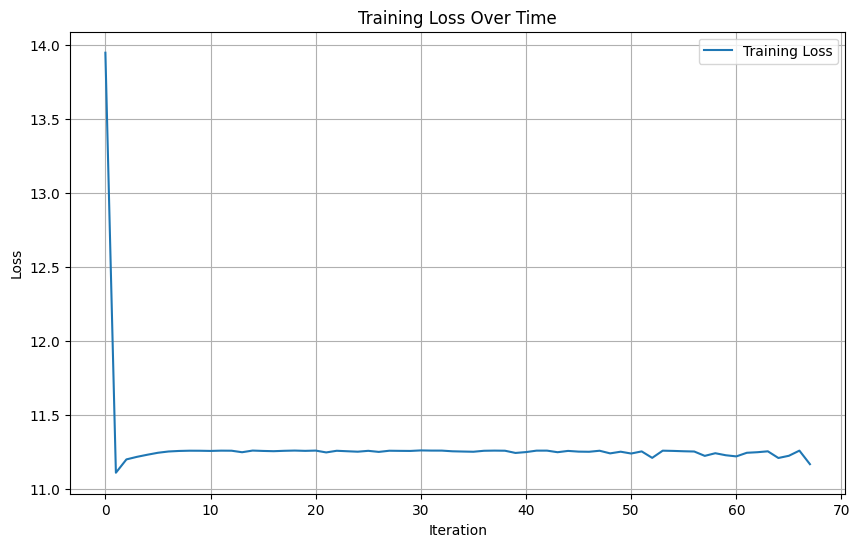

train count: 2000


In [32]:
data_size = 6
hidden_size = 1
width_size = 4
depth = 2

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=key())

eta = 0.005
optimizer = optax.adam(learning_rate=eta)

steps = 2000
batch_size = 8
seq_length = 32
eval_point_ratio = 0.3
subset_size = 1024

trained_model = train(
    model,
    data,
    optimizer,
    steps,
    batch_size,
    seq_length, 
    eval_point_ratio, 
    key(), 
    subset_size,
    plot_every=100,
    patience=10_000,
)